In [1]:
'''
使用已有模型进行预测并将结果可视化

主要改动：
1.将代码封装，统一管理参数,一键运行，便于下阶段制作图形界面。
2.读取文件前自动识别encoding。
3.加入审核点云点数的功能，如果点云太过稀疏，则插值增加点数到约3倍，使分割线更清晰；三角面片同步更新。
4.为0标签赋可调整的低权重，在预测结果中初步去洞。随后的形态学操作是第二轮去洞。
5.把分割线周围的点用邻域投票法补全。此举优点是避免分割线附近的裂缝，缺点是分割线色彩会暗淡。

目前已有的数据处理及作用：
为0标签赋低权   --  去洞，减少分割线的断裂
三阶插值上采样  --  去阶梯形分割线
形态学操作      --  去洞、收窄分割线
局部加权平滑    --  平滑分割线，去掉离群点
高斯滤波        --  平滑分割线，去掉高频
'''

'\n使用已有模型进行预测并将结果可视化\n\n主要改动：\n1.将代码封装，统一管理参数,一键运行，便于下阶段制作图形界面。\n2.读取文件前自动识别encoding。\n3.加入审核点云点数的功能，如果点云太过稀疏，则插值增加点数到约3倍，使分割线更清晰；三角面片同步更新。\n4.为0标签赋可调整的低权重，在预测结果中初步去洞。随后的形态学操作是第二轮去洞。\n5.把分割线周围的点用邻域投票法补全。此举优点是避免分割线附近的裂缝，缺点是分割线色彩会暗淡。\n\n目前已有的数据处理及作用：\n为0标签赋低权   --  去洞，减少分割线的断裂\n三阶插值上采样  --  去阶梯形分割线\n形态学操作      --  去洞、收窄分割线\n局部加权平滑    --  平滑分割线，去掉离群点\n高斯滤波        --  平滑分割线，去掉高频\n'

In [38]:
# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/李娅宁/肩台外侧点-0715/"

# 加载模型
model_load_path = r'Aug9分界/Aug10_150颗含姿态调整.h5' 


# 加载点云和mark
obj_file_path = r'Aug3/150颗0806新数据/35.obj'

# 设置去洞率
Hole_removal_rate = 0.5

In [3]:
import chardet
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import networkx as nx
import os
from scipy.interpolate import CubicSpline, splprep, splev
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
from scipy.ndimage import zoom, grey_dilation, grey_erosion, grey_closing, grey_opening, gaussian_filter1d
from sklearn.neighbors import NearestNeighbors, KDTree
import tensorflow as tf
import tensorflow.keras.backend as K

In [4]:
'''统一设置地址'''

os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())


修改后的工作目录： D:\李娅宁\肩台外侧点-0715


In [5]:
# 开启交互旋转
# %matplotlib notebook

In [6]:
'''定义各种损失函数'''

# 交叉熵
def cross_entropy_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))

# Dice
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3, 4])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3, 4]) + tf.reduce_sum(y_pred, axis=[1, 2, 3, 4])
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return tf.reduce_mean(1 - dice)

# Focal
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # 确保 y_true 和 y_pred 都是 float32 类型
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        # 计算交叉熵
        cross_entropy = -y_true * tf.math.log(y_pred)
        # 计算 focal 权重
        focal_weight = alpha * tf.math.pow(1 - y_pred, gamma)
        # 计算 focal loss
        loss = focal_weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fixed


# Tversky
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3, 4])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3, 4])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3, 4])
    
    tversky = (intersection + smooth) / (intersection + alpha * false_neg + beta * false_pos + smooth)
    
    return tf.reduce_mean(1 - tversky)


# 组合损失函数
@tf.function
def combined_loss(y_true, y_pred):
    ce_loss = cross_entropy_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    tversky = tversky_loss(y_true, y_pred)
    focal = focal_loss(gamma=2.0, alpha=0.25)(y_true, y_pred)
    
    return ce_loss + dice + tversky + focal


In [7]:
'''加载模型'''

# 自定义损失函数字典
custom_objects = {
    'cross_entropy_loss': cross_entropy_loss,
    'dice_loss': dice_loss,
    'focal_loss': focal_loss,
    'tversky_loss': tversky_loss,
    'combined_loss': combined_loss
}

try:
    model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects)
    print("模型加载成功！")
except Exception as e:
    print("模型加载失败:", e)

模型加载成功！


In [8]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import UnivariateSpline
import os
import matplotlib.pyplot as plt

def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']

def load_obj_file(file_path, encoding):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                if line.startswith('v '):
                    vertices.append(list(map(float, line.strip().split()[1:])))
                elif line.startswith('f '):
                    faces.append([int(idx.split('/')[0]) - 1 for idx in line.strip().split()[1:]])
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return np.asarray(vertices), np.asarray(faces)
   
def compute_bounding_box(points):
    """计算点云的包围盒"""
    min_point = np.min(points, axis=0)
    max_point = np.max(points, axis=0)
    bbox_size = max_point - min_point
    bbox_center = (min_point + max_point) / 2.0
    return bbox_size, bbox_center

def extract_top_subcloud(points, bbox_size, bbox_center, height=4.0):
    """提取y坐标在ymax到ymax-3范围内的子点云"""
    min_y = bbox_center[1] + bbox_size[1] / 2.0 - height
    top_subcloud = points[points[:, 1] >= min_y]
    return top_subcloud

def find_best_rotation(points, axis1, axis2, axis3, half_angle_range=int(90), angle_step=1):
    """绕axis1旋转，使得axis2（优先）、axis3方向包围盒尺寸最小，输出旋转矩阵"""
    min_size2 = float('inf')
    min_size3 = float('inf')
    best_rotation_matrix = None

    for angle in np.arange(-half_angle_range, half_angle_range, angle_step):
        # 绕指定轴旋转
        rotation_matrix = R.from_euler(axis1, angle, degrees=True).as_matrix()
        rotated_points = points.dot(rotation_matrix.T)
        
        # 计算包围盒尺寸
        bbox_size, _ = compute_bounding_box(rotated_points)
        
        # 找出目标轴之外的最小尺寸
        if axis2 == 'x':
            size2 = bbox_size[0]  # x方向宽度
        elif axis2 == 'y':
            size2 = bbox_size[1]  # z方向宽度
        elif axis2 == 'z':
            size2 = bbox_size[2]  # z方向宽度

        # 找出目标轴之外的最小尺寸
        if axis3 == 'x':
            size3 = bbox_size[0]  # x方向宽度
        elif axis3 == 'y':
            size3 = bbox_size[1]  # z方向宽度
        elif axis3 == 'z':
            size3 = bbox_size[2]  # z方向宽度

        # 如果当前尺寸比之前的最小尺寸还小，则更新
        if size2 < min_size2:
            min_size2 = size2
            min_size3 = size3
            best_rotation_matrix = rotation_matrix
        elif size2 == min_size2:
            if size3 <min_size3:
                min_size3 = size3
                best_rotation_matrix = rotation_matrix

    return best_rotation_matrix

def flatten_and_analyze_curve(points, z_threshold=0.3, y_offset=1.5):
    """在新x-y平面上分析曲线的曲率，并确定x、z方向。
    
    参数:
    - points: 点云数据，形状为 (n, 3)
    - z_threshold: 用于滤波的z坐标阈值
    - y_offset: 确定用于分裂曲线的横线 y=ymax-y_offset 的偏移量
    """
    # 提取平面内的点
    flat_points = points[np.abs(points[:, 2]) <= z_threshold]

    # 提取 x 和 y 坐标
    x_coords = flat_points[:, 0]
    y_coords = flat_points[:, 1]

    # 对 x_coords 和 y_coords 进行排序以确保 x_coords 严格递增
    sorted_indices = np.argsort(x_coords)
    x_coords = x_coords[sorted_indices]
    y_coords = y_coords[sorted_indices]

    # 确定 ymax - y_offset 这条横线
    ymax = np.max(y_coords)
    y_threshold = ymax - y_offset

    # 找到 y_coords 刚刚超过 y_threshold 的最小和最大索引
    above_threshold_indices = np.where(y_coords > y_threshold)[0]
    if len(above_threshold_indices) == 0:
        raise ValueError("没有点的y坐标超过指定的y_threshold")

    min_index = above_threshold_indices[0]
    max_index = above_threshold_indices[-1]

    # 使用这些索引作为左侧和右侧的分界点
    left_indices = np.where((y_coords <= y_threshold) & (x_coords <= x_coords[min_index]))[0]
    right_indices = np.where((y_coords <= y_threshold) & (x_coords >= x_coords[max_index]))[0]

    left_index = left_indices[np.argmin(np.abs(y_coords[left_indices] - y_threshold))]
    right_index = right_indices[np.argmin(np.abs(y_coords[right_indices] - y_threshold))]

    x2_left, y2_left = x_coords[left_index], y_coords[left_index]
    x2_right, y2_right = x_coords[right_index], y_coords[right_index]

    # 找到曲线的第一个点和最后一个点
    x1, y1 = x_coords[0], y_coords[0]
    x3, y3 = x_coords[-1], y_coords[-1]

    # 计算线段 (x1, y1)-(x2_left, y2_left) 和 (x2_right, y2_right)-(x3, y3) 的斜率
    slope_left = (y2_left - y1) / (x2_left - x1)
    slope_right = (y3 - y2_right) / (x3 - x2_right)

    # 计算两侧线段下方的点数占比
    left_side_points = flat_points[flat_points[:, 0] < x2_left]
    right_side_points = flat_points[flat_points[:, 0] >= x2_right]

    left_under_line = left_side_points[:, 1] < (slope_left * (left_side_points[:, 0] - x1) + y1)
    right_under_line = right_side_points[:, 1] < (slope_right * (right_side_points[:, 0] - x2_right) + y2_right)

    left_under_ratio = np.sum(left_under_line) / len(left_side_points)
    right_under_ratio = np.sum(right_under_line) / len(right_side_points)

    # 确定 x 方向：下凹一侧为 x 正方向
    x_direction = -1 if left_under_ratio > right_under_ratio else 1

    # 复制相同的旋转给 z 方向以保持手性
    z_direction = x_direction

    return x_direction, z_direction

def align_point_cloud(points):
    """处理并旋转点云"""  
    # 计算原始点云的包围盒
    bbox_size, bbox_center = compute_bounding_box(points)

    # 提取顶端子点云1：较短，用于找到最扁取向
    top_subcloud1 = extract_top_subcloud(points, bbox_size, bbox_center, height=3.0)

    # 找到使得点云最扁的旋转角度
    best_rotation_matrix = find_best_rotation(top_subcloud1, 'y', 'x', 'z')

    # 提取顶端子点云2：较长，用于对比唇舌侧的凸性
    top_subcloud2 = extract_top_subcloud(points, bbox_size, bbox_center, height=5.0)
    
    # 将子点云旋转到最佳角度
    rotated_subcloud = top_subcloud2.dot(best_rotation_matrix.T)
    
    # 在新x-y平面上分析曲线并确定x轴方向
    x_direction, z_direction = flatten_and_analyze_curve(rotated_subcloud)

    # 确定最终旋转矩阵
    new_x_axis = best_rotation_matrix[:, 0] * x_direction
    new_y_axis = best_rotation_matrix[:, 1]
    new_z_axis = best_rotation_matrix[:, 2] * z_direction

    best_rotation_matrix_y = np.column_stack((new_x_axis, new_y_axis, new_z_axis))

    # 旋转整个原始点云到新的坐标系
    aligned_points = points.dot(best_rotation_matrix_y.T)

    # 在z轴上进行进一步优化旋转
    best_rotation_matrix_z = find_best_rotation(aligned_points, 'z', 'x', 'y', half_angle_range=int(30))
    aligned_points = aligned_points.dot(best_rotation_matrix_z.T)

    # 在x轴上进行进一步优化旋转
    best_rotation_matrix_x = find_best_rotation(aligned_points, 'x', 'z', 'y', half_angle_range=int(30))
    aligned_points = aligned_points.dot(best_rotation_matrix_x.T)

    # 最终的旋转矩阵
    final_rotation_matrix = best_rotation_matrix_x.dot(best_rotation_matrix_z).dot(np.column_stack((new_x_axis, new_y_axis, new_z_axis)).T)

    return aligned_points, final_rotation_matrix

# 创建一个两行一列的子图布局
def plot_cloud_before_and_after_pose_adjustment(points, y_rotation_angle=0):
    """绘制结果"""
    aligned_points, _ = align_point_cloud(points)
    
    # 绘图
    fig = plt.figure(figsize=(14, 7))

    # 在第一个子图中显示原始点云
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='.')
    # 旋转视角，将y轴竖直并绕y轴旋转
    ax1.view_init(elev=90, azim=y_rotation_angle)
    # 设置图例
    ax1.set_title('Original Point Cloud')
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_zlabel('Z axis')

    # 保持原始点云各轴比例一致
    max_range = np.array([points[:, 0].max() - points[:, 0].min(),
                          points[:, 1].max() - points[:, 1].min(),
                          points[:, 2].max() - points[:, 2].min()]).max() / 2.0

    mid_x = (points[:, 0].max() + points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max() + points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max() + points[:, 2].min()) * 0.5

    ax1.set_xlim(mid_x - max_range, mid_x + max_range)
    ax1.set_ylim(mid_y - max_range, mid_y + max_range)
    ax1.set_zlim(mid_z - max_range, mid_z + max_range)

    # 在第二个子图中显示对齐后的点云
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(aligned_points[:, 0], aligned_points[:, 1], aligned_points[:, 2], c='r', marker='.')
    # 旋转视角，将y轴竖直并绕y轴旋转
    ax2.view_init(elev=90, azim=y_rotation_angle)
    # 设置图例
    ax2.set_title('Aligned Point Cloud')
    ax2.set_xlabel('X axis')
    ax2.set_ylabel('Y axis')
    ax2.set_zlabel('Z axis')

    # 设置对齐后的点云的坐标轴范围，使得每个轴的单位长度相同
    max_range_aligned = np.array([aligned_points[:, 0].max() - aligned_points[:, 0].min(),
                                  aligned_points[:, 1].max() - aligned_points[:, 1].min(),
                                  aligned_points[:, 2].max() - aligned_points[:, 2].min()]).max() / 2.0

    mid_x_aligned = (aligned_points[:, 0].max() + aligned_points[:, 0].min()) * 0.5
    mid_y_aligned = (aligned_points[:, 1].max() + aligned_points[:, 1].min()) * 0.5
    mid_z_aligned = (aligned_points[:, 2].max() + aligned_points[:, 2].min()) * 0.5

    ax2.set_xlim(mid_x_aligned - max_range_aligned, mid_x_aligned + max_range_aligned)
    ax2.set_ylim(mid_y_aligned - max_range_aligned, mid_y_aligned + max_range_aligned)
    ax2.set_zlim(mid_z_aligned - max_range_aligned, mid_z_aligned + max_range_aligned)

    plt.show()

    return aligned_points





In [9]:
'''预测和初步可视化'''


def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

def insert_midpoint_points(vertices, faces, minimum_vertices_number=5000):
    if len(vertices) >= minimum_vertices_number:
        print('原始点云的点数足够多')
        return vertices, faces

    else:
        temp = 0
        while len(vertices) < minimum_vertices_number:
            edge_to_midpoint = {}
            new_points = []
            new_faces = []
            vertex_offset = len(vertices)
    
            for face in faces:
                # Compute midpoints for each edge
                midpoints = []
                for i in range(len(face)):
                    edge = tuple(sorted((face[i], face[(i + 1) % len(face)])))
                    if edge not in edge_to_midpoint:
                        midpoint = np.mean([vertices[edge[0]], vertices[edge[1]]], axis=0)
                        edge_to_midpoint[edge] = vertex_offset + len(new_points)
                        new_points.append(midpoint.tolist())
                    midpoints.append(edge_to_midpoint[edge])
                
                # Original vertices
                v0, v1, v2 = face
                # Midpoints
                m0, m1, m2 = midpoints

                # Create four new faces
                new_faces.append([v0, m0, m2])
                new_faces.append([v1, m1, m0])
                new_faces.append([v2, m2, m1])
                new_faces.append([m0, m1, m2])
    
            vertices.extend(new_points)
            faces = new_faces
            temp += 1

        print(f'使用了 {temp} 轮插值来让点云点数满足要求')
        
    return vertices, faces

def create_voxel_grid(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]] += 1 # +=1 表示考虑局部点云密度，=1则表示不考虑点云密度
    
    return voxel_grid, min_coords, voxel_dim

def get_probabilities_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    
    # predictions should have shape (1, grid_size, grid_size, grid_size, num_classes)
    # Remove batch dimension
    probabilities = np.squeeze(predictions, axis=0)  # Shape: (grid_size, grid_size, grid_size, num_classes)
    
    return probabilities

def upscale_voxel_grid_and_probs(voxel_grid, probs, new_grid_size):
    old_size = voxel_grid.shape[0]
    scale_factor = new_grid_size / old_size

    # 使用最近邻插值来放大二进制体素网格
    new_voxel_grid = zoom(voxel_grid, zoom=scale_factor, order=0)  # 使用最近邻插值

    # 放大概率
    num_classes = probs.shape[-1]
    upscaled_probs = np.zeros((new_grid_size, new_grid_size, new_grid_size, num_classes), dtype=np.float32)
    
    for i in range(num_classes):
        prob_class = probs[..., i]
        prob_class_upscaled = zoom(prob_class, zoom=scale_factor, order=3)  # 使用三次插值
        upscaled_probs[..., i] = prob_class_upscaled

    return new_voxel_grid, upscaled_probs


'''
自定义形态学操作
'''
def generalized_closing(prob_class, dilation_iterations, erosion_iterations, structure_size):
    """
    执行广义闭运算：多次膨胀后多次腐蚀。
    :param prob_class: 概率图的某一类别，形状为 (grid_size, grid_size, grid_size)
    :param dilation_iterations: 膨胀的次数
    :param erosion_iterations: 腐蚀的次数
    :param structure_size: 结构元素的大小
    :return: 广义闭运算后的概率图
    """
    structure = np.ones((structure_size, structure_size, structure_size))
    
    # 多次膨胀
    for _ in range(dilation_iterations):
        prob_class = grey_dilation(prob_class, structure=structure)
    
    # 多次腐蚀
    for _ in range(erosion_iterations):
        prob_class = grey_erosion(prob_class, structure=structure)
    
    return prob_class

def generalized_opening(prob_class, opening_iterations, structure_size):
    """
    执行广义开运算：多次开运算迭代。
    :param prob_class: 概率图的某一类别，形状为 (grid_size, grid_size, grid_size)
    :param opening_iterations: 开运算的次数
    :param structure_size: 结构元素的大小
    :return: 广义开运算后的概率图
    """
    structure = np.ones((structure_size, structure_size, structure_size))
    
    # 多次开运算
    for _ in range(opening_iterations):
        prob_class = grey_opening(prob_class, structure=structure)
    
    return prob_class

def morphological_adjustment(probabilities, labels, dilation_iterations, erosion_iterations, opening_iterations, structure_size, adjustment_iterations):
    """
    对指定标签的概率进行形态学调整：先执行广义闭运算，再执行广义开运算。
    
    :param probabilities: 概率图，形状为 (grid_size, grid_size, grid_size, num_classes)
    :param labels: 要进行形态学调整的标签列表
    :param dilation_iterations: 每阶段膨胀的次数
    :param erosion_iterations: 每阶段腐蚀的次数
    :param opening_iterations: 开运算的次数
    :param structure_size: 结构元素的大小，定义为立方体的边长
    :param adjustment_iterations: 广义闭运算和广义开运算的循环次数
    :return: 形态学调整后的概率图
    """
    num_classes = probabilities.shape[-1]
    adjusted_probabilities = np.copy(probabilities)
    
    for _ in range(adjustment_iterations):
        for label in labels:
            prob_class = adjusted_probabilities[..., label]
            
            # 执行广义闭运算
            prob_class = generalized_closing(prob_class, dilation_iterations, erosion_iterations, structure_size)
            
            # 执行广义开运算
            prob_class = generalized_opening(prob_class, opening_iterations, structure_size)
            
            adjusted_probabilities[..., label] = prob_class
    
    return adjusted_probabilities



def apply_labels_to_point_cloud(data, predicted_probabilities, min_coords, original_voxel_dim, original_grid_size, new_grid_size):
    labels = np.zeros(len(data))
    # 重新计算放大后的体素维度
    voxel_dim = (original_voxel_dim * original_grid_size) / new_grid_size
    
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, new_grid_size-1)
        labels[i] = np.argmax(predicted_probabilities[voxel[0], voxel[1], voxel[2]])
    return labels

def build_topology_graph(vertices, k=10):

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(vertices)
    distances, indices = nbrs.kneighbors(vertices)
    
    G = nx.Graph()
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                G.add_edge(i, j)
                
    return G

def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T
    
    # 绘制不同标签区域的点云
    colors = ['lightgreen', 'cornflowerblue', 'honeydew']
    for i in range(3):
        part_faces = [face for face in faces if sum(labels[vertex] == i for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.6)
    
    # 绘制边界线
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T




Encoding: ascii


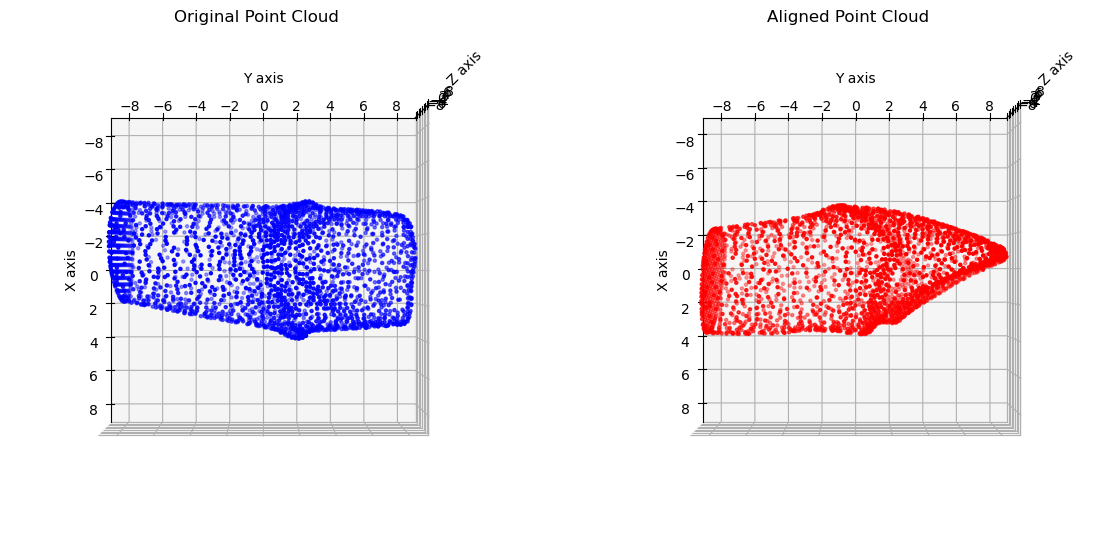

Number of vertices:  2460
使用了 1 轮插值来让点云点数满足要求
Number of checked vertices:  9834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Shape of predicted_probabilities: (16, 16, 16, 3)
Unique values in predicted_probabilities: [0.0000000e+00 2.3743579e-38 2.4253290e-38 ... 9.9997401e-01 9.9998176e-01
 9.9999440e-01]
Shape of upscaled_voxel_grid: (80, 80, 80)
Shape of upscaled_probabilities: (80, 80, 80, 3)
Unique values in upscaled_probabilities: [-0.3854595  -0.38484117 -0.35936508 ...  1.3891587   1.3962754
  1.3977408 ]


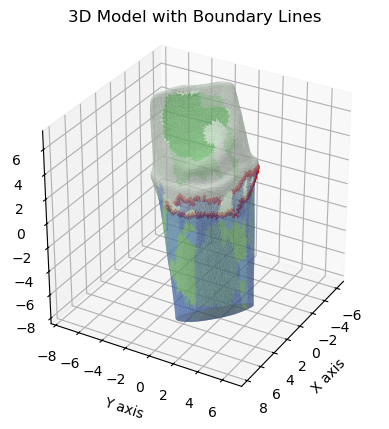

In [39]:
# 加载点云数据
vertice_encoding = detect_encoding(obj_file_path)
print(f'Encoding: {vertice_encoding}')
vertices, faces = load_obj_file(obj_file_path, vertice_encoding)
centered_vertices = center_vertices(vertices)
centered_vertices = plot_cloud_before_and_after_pose_adjustment(np.asarray(centered_vertices))
centered_vertices = centered_vertices.tolist()
print('Number of vertices: ',len(centered_vertices))
checked_centered_vertices, faces = insert_midpoint_points(centered_vertices, faces, minimum_vertices_number=5000)
print('Number of checked vertices: ',len(checked_centered_vertices))

# 将点云转换为体素网格
original_grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, original_voxel_dim = create_voxel_grid(np.array(checked_centered_vertices), original_grid_size)

# 使用训练好的模型进行预测
predicted_probabilities = get_probabilities_from_model(model, voxel_grid)
predicted_probabilities[:,:,:,0] = Hole_removal_rate * predicted_probabilities[:,:,:,0] # 更改标签0的权重，去洞
print("Shape of predicted_probabilities:", predicted_probabilities.shape)
print("Unique values in predicted_probabilities:", np.unique(predicted_probabilities))

# 等比扩大体素网格
new_grid_size = 80  # <64 时边缘带阶梯形，>128 时面上带洞
upscaled_voxel_grid, upscaled_probabilities = upscale_voxel_grid_and_probs(voxel_grid, predicted_probabilities, new_grid_size)
print("Shape of upscaled_voxel_grid:", upscaled_voxel_grid.shape)
print("Shape of upscaled_probabilities:", upscaled_probabilities.shape)
print("Unique values in upscaled_probabilities:", np.unique(upscaled_probabilities))


# 形态学操作
# 定义膨胀和腐蚀的次数
structure_size = 3  # 结构元素的大小，大于等于3，越大越快越粗糙，因此必须调最小
dilation_iterations = 10  # 每阶段膨胀的次数，决定了能填多大的洞，也决定了边缘会受多大影响
erosion_iterations = 10  # 每阶段腐蚀的次数，同上，应当在不影响边缘精度的条件下尽可能大
opening_iterations = 5  # 广义开运算中开运算的迭代次数，越多边缘越细，5以上区别不明显
adjustment_iterations = 1  # 广义闭运算和开运算的循环次数，没啥影响，越大越慢所以取最小值1
# 对上采样后的概率进行形态学调整
adjusted_probabilities = morphological_adjustment(upscaled_probabilities, labels=[1, 2], 
                                                  dilation_iterations=dilation_iterations, erosion_iterations=erosion_iterations, 
                                                  opening_iterations=opening_iterations, 
                                                  structure_size=structure_size, adjustment_iterations=adjustment_iterations)
# print("Shape of adjusted_probabilities:", adjusted_probabilities.shape)
# print("Unique values in adjusted_probabilities:", np.unique(adjusted_probabilities))

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(checked_centered_vertices, adjusted_probabilities, min_coords, original_voxel_dim, original_grid_size, new_grid_size)
# print("Shape of predicted_point_labels:", predicted_point_labels.shape)
# print("Predicted_point_labels:", predicted_point_labels)
# print("Unique values in predicted_point_labels:", np.unique(predicted_point_labels))


# 构建拓扑图
G = build_topology_graph(checked_centered_vertices)

# 找到最大连通子图
target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 找到边界线
boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])
# print('Boundary:', boundary_edges)

# 绘制点云及边界线
plot_surface_with_boundary_lines(checked_centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


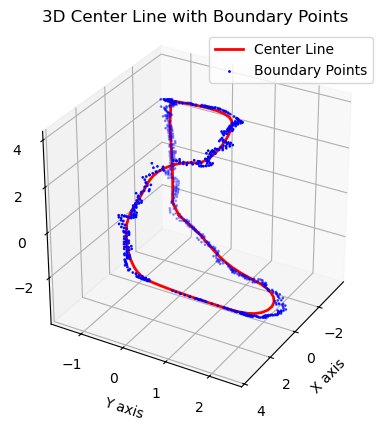

In [35]:
'''轮廓线重建'''
'''发现bug：绘制插值线时只靠临近优先无法有效避免起点处的折返，一旦起点附近有绿斑，插值线可能会在绿斑处折返'''

# 局部加权平滑函数
def local_weighted_smooth(x, y, z, window_size=5, sigma=1.0):
    def smooth1d(data, window_size, sigma):
        smoothed = np.copy(data)
        for i in range(len(data)):
            start = max(0, i - window_size // 2)
            end = min(len(data), i + window_size // 2 + 1)
            weights = np.exp(-0.5 * ((np.arange(start, end) - i) ** 2) / sigma ** 2)
            weights /= weights.sum()
            smoothed[i] = np.dot(weights, data[start:end])
        return smoothed

    x_smoothed = smooth1d(x, window_size, sigma)
    y_smoothed = smooth1d(y, window_size, sigma)
    z_smoothed = smooth1d(z, window_size, sigma)
    
    return x_smoothed, y_smoothed, z_smoothed

# 计算边界线中点
def calculate_midpoints(boundary_edges, vertices):
    midpoints = []
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        midpoint = (p1 + p2) / 2
        midpoints.append(midpoint)
    return np.array(midpoints)

# 创建体素网格
def create_voxel_grid_for_boundary(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=object)
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                voxel_grid[i, j, k] = []

    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]].append(point)
    
    return voxel_grid, min_coords, voxel_dim

# 计算体素重心
def calculate_voxel_centroids(voxel_grid, grid_size):
    centroids = []
    for i in range(grid_size):
        for j in range(grid_size):
            for k in range(grid_size):
                points_in_voxel = voxel_grid[i, j, k]
                if points_in_voxel:
                    centroid = np.mean(points_in_voxel, axis=0)
                    centroids.append(centroid)
    return np.array(centroids)

# 通过最近邻方法排序点
def order_points(points):
    points = np.array(points)
    if len(points) < 2:
        return points
    
    n = points.shape[0]
    ordered_points = [points[0]]
    visited = {0}
    
    for _ in range(1, n):
        last_point = ordered_points[-1].reshape(1, -1)
        distances = distance_matrix(last_point, points)[0]
        distances[list(visited)] = np.inf
        next_point_index = np.argmin(distances)
        visited.add(next_point_index)
        ordered_points.append(points[next_point_index])
    
    return np.array(ordered_points)

# 拟合平滑曲线
def fit_smooth_curve(points, num_points=100, smooth_factor1=1.0, window_size=5, smooth_factor2=2):
    if len(points) < 2:
        return points
    
    ordered_points = order_points(points)
    
    x = ordered_points[:, 0]
    y = ordered_points[:, 1]
    z = ordered_points[:, 2]
    
    t = np.arange(len(x))
    
    # Ensure the curve is closed by adding the first point at the end
    x = np.concatenate([x, [x[0]]])
    y = np.concatenate([y, [y[0]]])
    z = np.concatenate([z, [z[0]]])
    t = np.concatenate([t, [t[-1] + 1]])
    
    # Fit cubic spline with periodic boundary conditions
    cs_x = CubicSpline(t, x, bc_type='periodic')
    cs_y = CubicSpline(t, y, bc_type='periodic')
    cs_z = CubicSpline(t, z, bc_type='periodic')
    
    t_new = np.linspace(0, len(t) - 1, num=num_points)
    x_new = cs_x(t_new)
    y_new = cs_y(t_new)
    z_new = cs_z(t_new)

    # Ensure the curve is closed by adding the first point at the end
    x_new = np.concatenate([x_new, [x_new[0]]])
    y_new = np.concatenate([y_new, [y_new[0]]])
    z_new = np.concatenate([z_new, [z_new[0]]])
    t_new = np.concatenate([t_new, [t_new[-1] + 1]])
    
    # Apply local weighted smoothing
    x_smoothed, y_smoothed, z_smoothed = local_weighted_smooth(x_new, y_new, z_new, window_size, smooth_factor1)
    
    # Apply Gaussian filter to smooth the curve
    x_smoothed = gaussian_filter1d(x_smoothed, sigma=smooth_factor2)
    y_smoothed = gaussian_filter1d(y_smoothed, sigma=smooth_factor2)
    z_smoothed = gaussian_filter1d(z_smoothed, sigma=smooth_factor2)

    # Ensure the curve is closed by adding the first point at the end
    x_smoothed = np.concatenate([x_smoothed, [x_smoothed[0]]])
    y_smoothed = np.concatenate([y_smoothed, [y_smoothed[0]]])
    z_smoothed = np.concatenate([z_smoothed, [z_smoothed[0]]])
    
    return np.vstack([x_smoothed, y_smoothed, z_smoothed]).T

# 绘制中心线
def plot_center_line(center_line, boundary_midpoints, view_angles=(30, 30)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = center_line.T
    ax.plot(x, y, z, color='red', lw=2, label='Center Line')
    
    bx, by, bz = boundary_midpoints.T
    ax.scatter(bx, by, bz, color='blue', s=1, label='Boundary Points')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Center Line with Boundary Points')

    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)

    ax.set_box_aspect([1,1,1])

    plt.legend()
    plt.show()
    

# 主程序
boundary_midpoints = calculate_midpoints(boundary_edges, np.array(checked_centered_vertices))
grid_size = 10
voxel_grid, min_coords, voxel_dim = create_voxel_grid_for_boundary(boundary_midpoints, grid_size)
voxel_centroids = calculate_voxel_centroids(voxel_grid, grid_size)

if len(voxel_centroids) < 2:
    raise ValueError("Not enough points to fit a smooth curve.")

# smooth_factor1是局部加权平滑因子，值越大，平均带越宽、曲线越平滑，大于2以后结果趋于稳定；window size是每个像素处的参考点数，太小无效，太大丢细节
# smooth_factor2是高斯滤波的平滑因子，同上——也是个sigma;效果不好，<1 时效果不明显,>2 时会失真
smooth_center_line = fit_smooth_curve(voxel_centroids, smooth_factor1=2, window_size=5, smooth_factor2=1.5)  
plot_center_line(smooth_center_line, boundary_midpoints)


Trying with tolerance: 0.10
Number of inside points: 94
Trying with tolerance: 0.12
Number of inside points: 151
Trying with tolerance: 0.14
Number of inside points: 207
Trying with tolerance: 0.16
Number of inside points: 262
Number of vertices in part 1: 9392
Number of vertices in part 2: 22


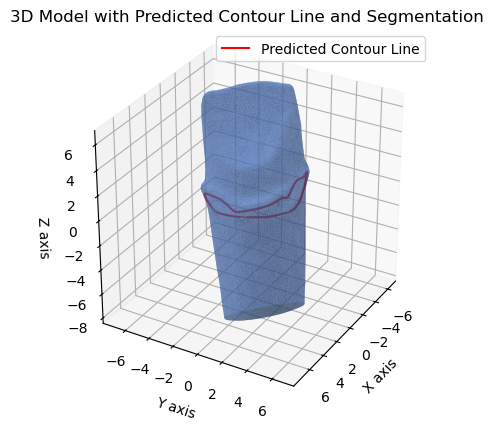

In [12]:
'''最终图像'''

def generate_graph(vertices, faces):
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i+1) % len(face)])
    return G

def is_on_curve(vertex, curve_points, tolerance):
    for point in curve_points:
        if np.linalg.norm(vertex - point) < tolerance:
            return True
    return False


def segment_point_cloud(vertices, faces, smooth_center_line):
    tolerance = 0.1
    max_tolerance = 1.0
    tolerance_increment = 0.02

    while tolerance <= max_tolerance:
        G = generate_graph(vertices, faces)
        curve_points = np.array(smooth_center_line)
        
        # 找到封闭曲线上的顶点
        curve_points_indices = set()
        for i, vertex in enumerate(vertices):
            if is_on_curve(np.array(vertex), curve_points, tolerance):
                curve_points_indices.add(i)
        
        print(f"Trying with tolerance: {tolerance:.2f}")
        print(f"Number of inside points: {len(curve_points_indices)}")
        
        # 从图中删除封闭曲线上的点
        G.remove_nodes_from(curve_points_indices)
        
        # 使用图的连通性找到两个区域
        components = list(nx.connected_components(G))
        if len(components) > 1:
            part1 = components[0]
            part2 = components[1]
            
            # 创建 KDTree 以高效地查找邻域
            vertices_array = np.array(vertices)
            tree = KDTree(vertices_array)
            
            # 创建临时集合以存储每个曲线点的分配结果
            part1_curve_points = set()
            part2_curve_points = set()
            
            # 设置邻域半径的初始值和最大值
            r_min = 0.2
            r_max = 1.0
            r_increment = 0.2
            
            # 对每个曲线点进行投票
            for i in curve_points_indices:
                vertex = vertices[i]
                
                # 初始化邻域半径
                r = r_min
                found_valid_neighbor = False
                
                while r <= r_max:
                    # 查找邻居
                    neighbors = tree.query_radius([vertex], r=r)[0]
                    if len(neighbors) > 2:
                        found_valid_neighbor = True
                        break
                    r += r_increment
                
                if not found_valid_neighbor:
                    # 如果没有找到有效邻居，跳过该点
                    continue
                
                # 如果找到有效邻居，进行投票
                # 计算每个类别的邻居数量
                num_part1_neighbors = sum(n in part1 for n in neighbors)
                num_part2_neighbors = sum(n in part2 for n in neighbors)
                
                # 投票决策
                if num_part1_neighbors > num_part2_neighbors:
                    part1_curve_points.add(i)
                elif num_part2_neighbors > num_part1_neighbors:
                    part2_curve_points.add(i)
                else:
                    # 如果邻居类别数量相等，选择距离最近的邻居的类别
                    distances = np.linalg.norm(vertices_array[neighbors] - vertex, axis=1)
                    closest_neighbor_index = np.argmin(distances)
                    closest_neighbor = neighbors[closest_neighbor_index]
                    if closest_neighbor in part1:
                        part1_curve_points.add(i)
                    else:
                        part2_curve_points.add(i)
            
            # 更新 part1 和 part2
            part1 = part1.union(part1_curve_points)
            part2 = part2.union(part2_curve_points)
            
            return part1, part2
        else:
            tolerance += tolerance_increment
    
    print("Segmentation failed: Unable to find two separate components.")
    return set(), set()


def plot_surface_with_predicted_points(vertices, faces, smooth_center_line, part1, part2, angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)

    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if set(face) & part1]
        part2_faces = [face for face in faces if set(face) & part2]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 插值标记点并绘制曲线
    smooth_center_line = rotate_points(smooth_center_line, angles)
    smooth_center_line = np.vstack([smooth_center_line, smooth_center_line[0]])  # 添加第一个点到最后，使曲线闭合
    ax.plot(smooth_center_line[:, 0], smooth_center_line[:, 1], smooth_center_line[:, 2], c='red', label='Predicted Contour Line')
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Predicted Contour Line and Segmentation')

    # 添加图例
    ax.legend()

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    ax.view_init(elev=30, azim=30)  # This will be overridden by rotation

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()


# 分割点云
part1_predicted, part2_predicted = segment_point_cloud(checked_centered_vertices, faces, smooth_center_line)

# 输出每个部分的点数
print(f"Number of vertices in part 1: {len(part1_predicted)}")
print(f"Number of vertices in part 2: {len(part2_predicted)}")

# 调整视角 (angles in radians)
plot_surface_with_predicted_points(checked_centered_vertices, faces, smooth_center_line, part1_predicted, part2_predicted, angles=(np.radians(90), np.radians(-30), np.radians(30)))


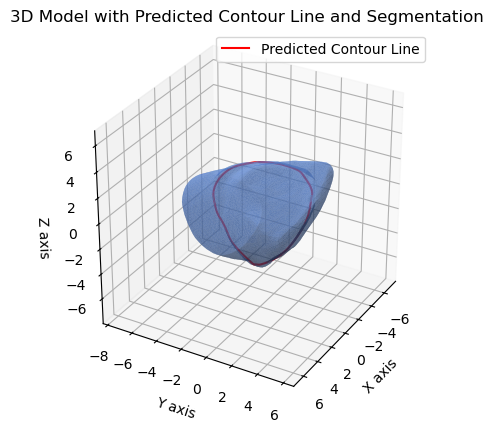

In [13]:
# 调整视角 (angles in radians)
plot_surface_with_predicted_points(checked_centered_vertices, faces, smooth_center_line, part1_predicted, part2_predicted, angles=(np.radians(40), np.radians(-40), np.radians(-70)))
